# Discovery Notebook

## Imports and Config

In [1]:
import os, sys, toml, pprint
import pandas as pd
import torch
from tqdm import tqdm

# JARVIS
from jarvis.db.figshare import data

# Add system path for custom modules
SYS_PATH = "../"
sys.path.append(SYS_PATH)

# Load configuration
CONFIG_PATH = f"{SYS_PATH}/config_multimodal.toml"
config = toml.load(CONFIG_PATH)
pprint.pprint(config)

# Project modules
from logger_utils import setup_logger, flush_logger
from jarvis_utils import load_or_fetch_dataset
from data_utils import add_candidate_column, build_element_vocab, formula_to_counts
from model_utils import CandidateNetMultimodal
from train_utils import load_checkpoint
from eval_utils import evaluate


{'data': {'dataset_name': 'dft_3d', 'store_dir': '/workspace/data/jarvis'},
 'filters': {'bandgap_column': 'optb88vdw_bandgap',
             'ehull': 0.1,
             'max_eps': 10.0,
             'min_eps': 1.0,
             'semiconductor_max': 4.0,
             'semiconductor_min': 0.5,
             'toxic_elements': ['Pb', 'Cd', 'Hg', 'As', 'Se'],
             'transparent_min': 3.0},
 'logging': {'enable': True,
             'file': '/workspace/data/jarvis/project_gnn_v2_30_epoch.log',
             'level': 'INFO'},
 'model': {'categorical': {'crys': {'embed_dim': 4, 'vocab_size': 8},
                           'dimensionality': {'embed_dim': 4, 'vocab_size': 8},
                           'func': {'embed_dim': 1, 'vocab_size': 2},
                           'spg_number': {'embed_dim': 50, 'vocab_size': 214},
                           'typ': {'embed_dim': 1, 'vocab_size': 2}},
           'checkpoint': {'path': '/workspace/data/jarvis/gnn_v2_30_epoch_checkpoint.pth'},
           

## Logger and Device

In [2]:
store_dir = config["data"]["store_dir"]
log_file  = os.path.basename(config["logging"]["file"])
base_name = os.path.splitext(log_file)[0]

os.makedirs(store_dir, exist_ok=True)

logger = setup_logger(config)
logger.info("Discovery notebook started")
flush_logger(logger)

model_cfg = config["model"]
device = torch.device(model_cfg["devices"]["model"] if torch.cuda.is_available() else "cpu")


2025-12-12 23:45:58,173 - jarvis_project - INFO - Discovery notebook started


# Data loading and preparation

In [3]:
# Fetch/load dataset
df = load_or_fetch_dataset(
    config["data"]["dataset_name"],
    data,                     
    store_dir    
)

logger.info(f"Dataset shape: {df.shape}")

# Candidate filtering -> target column
df = add_candidate_column(df, {
    "filters": {
        "bandgap_column": "optb88vdw_bandgap",
        "semiconductor_min": 0.5,
        "semiconductor_max": 5.0,
        "transparent_min": 2.5,
        "toxic_elements": ["Pb", "Cd", "As", "Hg"],
        "ehull": 0.1
    }
})
df = df.rename(columns={"target": "target"})  # explicit for clarity

# Numeric features
numeric_cols = model_cfg["num_cols"]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce").fillna(0.0)

# Categorical indices
cat_cols = list(model_cfg["categorical"].keys())
for col in cat_cols:
    codes, uniques = pd.factorize(df[col].fillna("UNK").astype(str))
    df[f"{col}_idx"] = codes

# Atoms object column
import ast
from jarvis.core.atoms import Atoms

def ensure_atoms_obj(df):
    def to_atoms(x):
        try:
            d = ast.literal_eval(x) if isinstance(x, str) else x
            return Atoms.from_dict(d)
        except Exception:
            return None
    return df["atoms"].apply(to_atoms) if "atoms" in df.columns else pd.Series([None]*len(df))

if "atoms_obj" not in df.columns:
    df["atoms_obj"] = ensure_atoms_obj(df)

# Element vocab and formula counts
element_vocab = build_element_vocab(df, max_elements=model_cfg["formula"]["num_elements"])
num_elements = model_cfg["formula"]["num_elements"]
df["formula_counts"] = df["formula"].apply(lambda f: formula_to_counts(f, element_vocab, num_elements))


2025-12-12 23:45:59,428 - jarvis_project - INFO - Dataset shape: (75993, 64)


Dataset shape: (75993, 64)


# Data loading and preparation

In [4]:
# Fetch/load dataset
df = load_or_fetch_dataset(
    config["data"]["dataset_name"],
    data,                     
    store_dir    
)

logger.info(f"Dataset shape: {df.shape}")

# Candidate filtering -> target column
df = add_candidate_column(df, {
    "filters": {
        "bandgap_column": "optb88vdw_bandgap",
        "semiconductor_min": 0.5,
        "semiconductor_max": 5.0,
        "transparent_min": 2.5,
        "toxic_elements": ["Pb", "Cd", "As", "Hg"],
        "ehull": 0.1
    }
})
df = df.rename(columns={"target": "target"})  # explicit for clarity

# Numeric features
numeric_cols = model_cfg["num_cols"]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce").fillna(0.0)

# Categorical indices
cat_cols = list(model_cfg["categorical"].keys())
for col in cat_cols:
    codes, uniques = pd.factorize(df[col].fillna("UNK").astype(str))
    df[f"{col}_idx"] = codes

# Atoms object column
import ast
from jarvis.core.atoms import Atoms

def ensure_atoms_obj(df):
    def to_atoms(x):
        try:
            d = ast.literal_eval(x) if isinstance(x, str) else x
            return Atoms.from_dict(d)
        except Exception:
            return None
    return df["atoms"].apply(to_atoms) if "atoms" in df.columns else pd.Series([None]*len(df))

if "atoms_obj" not in df.columns:
    df["atoms_obj"] = ensure_atoms_obj(df)

# Element vocab and formula counts
element_vocab = build_element_vocab(df, max_elements=model_cfg["formula"]["num_elements"])
num_elements = model_cfg["formula"]["num_elements"]
df["formula_counts"] = df["formula"].apply(lambda f: formula_to_counts(f, element_vocab, num_elements))


2025-12-12 23:46:07,399 - jarvis_project - INFO - Dataset shape: (75993, 64)


Dataset shape: (75993, 64)


## Prepare Model + Checkpoint

In [5]:
# Build vocab
element_vocab = build_element_vocab(df, max_elements=model_cfg["formula"]["num_elements"])
num_elements = model_cfg["formula"]["num_elements"]
df["formula_counts"] = df["formula"].apply(lambda f: formula_to_counts(f, element_vocab, num_elements))

# Model
model = CandidateNetMultimodal(model_cfg).to(device)

# Restore checkpoint
checkpoint_cfg = model_cfg.get("checkpoint", {})
checkpoint_path = checkpoint_cfg.get("path")
if checkpoint_path and os.path.exists(checkpoint_path):
    model, _, _, _ = load_checkpoint(model, None, checkpoint_path, device)
    logger.info(f"Checkpoint restored from {checkpoint_path}")


2025-12-12 23:46:14,158 - jarvis_project - INFO - Checkpoint restored from /workspace/data/jarvis/gnn_v2_30_epoch_checkpoint.pth


## Full Dataset Evaluation

Evaluating: 100%|█████████████████████████████████████████████████| 75/75 [03:39<00:00,  2.93s/batch]


Full Dataset -- Acc: 0.987 | Prec: 0.835 | Rec: 0.964 | F1: 0.895 | AUC: 0.997
Classification Report:
              precision    recall  f1-score   support

         0.0      0.998     0.989     0.993     71804
         1.0      0.835     0.964     0.895      4189

    accuracy                          0.987     75993
   macro avg      0.916     0.976     0.944     75993
weighted avg      0.989     0.987     0.988     75993

Confusion matrix figure saved to: /workspace/data/jarvis/project_gnn_v2_30_epoch_confusion_matrix.png
Figure: Confusion matrix for the multimodal GNN model (Full Dataset) at threshold 0.91. The heatmap shows counts of true negatives, false positives, false negatives, and true positives.


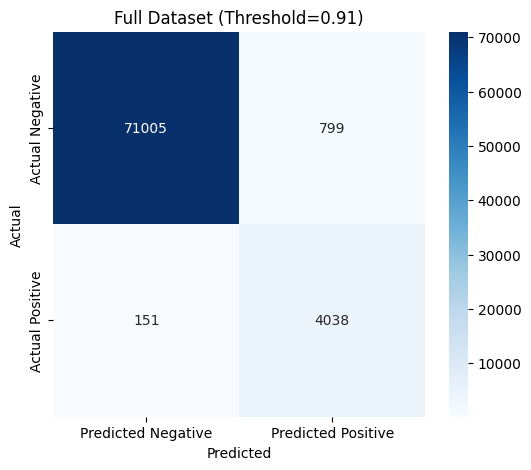

Full dataset metrics:
Acc=0.987, Prec=0.835, Rec=0.964, F1=0.895, AUC=0.997
Confusion matrix figure: /workspace/data/jarvis/project_gnn_v2_30_epoch_confusion_matrix.png
Caption: Figure: Confusion matrix for the multimodal GNN model (Full Dataset) at threshold 0.91. The heatmap shows counts of true negatives, false positives, false negatives, and true positives.


In [6]:
from torch.utils.data import DataLoader
from data_utils import MaterialsDataset, collate_single

full_ds = MaterialsDataset(df, model_cfg, element_vocab, num_elements, device=device)
full_loader = DataLoader(full_ds, batch_size=model_cfg.get("training", {}).get("batch_size", 32),
                         shuffle=False, collate_fn=collate_single)

threshold = model_cfg.get("threshold", 0.5)

full_acc, full_prec, full_rec, full_f1, full_auc, full_cm_path, full_cm_caption = evaluate(
    model, full_loader, threshold=threshold, title="Full Dataset",
    base_name=base_name, store_dir=store_dir
)

print("Full dataset metrics:")
print(f"Acc={full_acc:.3f}, Prec={full_prec:.3f}, Rec={full_rec:.3f}, F1={full_f1:.3f}, AUC={full_auc:.3f}")
print("Confusion matrix figure:", full_cm_path)
print("Caption:", full_cm_caption)


## Restore Atoms Column

In [7]:
# Ensure atoms column is restored
if "atoms" not in df.columns and "atoms_obj" in df.columns:
    # If atoms_obj exists, convert back to dict
    df["atoms"] = df["atoms_obj"].apply(lambda a: a.to_dict() if a is not None else None)

elif "atoms" not in df.columns:
    # Merge from original dataset if needed
    orig_df = load_or_fetch_dataset(config["data"]["dataset_name"], data, store_dir)
    if "atoms" in orig_df.columns:
        df = df.merge(orig_df[["id", "atoms"]], on="id", how="left")


## List Top Candidates

In [8]:
import numpy as np

# Put model in eval mode
model.eval()
y_prob, y_true, ids = [], [], []

with torch.no_grad():
    #for X_num, X_cat_dict, counts, graphs, y in full_loader:
    for X_num, X_cat_dict, counts, graphs, y in tqdm(full_loader, desc="Evaluating", unit="batch"):
        logits = model(X_num, X_cat_dict, counts, graphs)
    
        logits = model(X_num, X_cat_dict, counts, graphs)
        probs = torch.sigmoid(logits).cpu().numpy().ravel()
        y_prob.extend(probs.tolist())
        y_true.extend(y.cpu().numpy().ravel().tolist())

# Attach probabilities to dataframe
df["pred_prob"] = np.array(y_prob)


Evaluating: 100%|█████████████████████████████████████████████████| 75/75 [04:22<00:00,  3.49s/batch]


In [9]:
# Attach probabilities and true labels to dataframe
df["pred_prob"] = np.array(y_prob)
df["true_label"] = np.array(y_true)

# False positives = predicted positive (high prob) but true_label == 0
false_positives = df[df["true_label"] == 0].sort_values("pred_prob", ascending=False)

# Take top 9 false positives
top_false_candidates = false_positives.head(9)



In [10]:
# Display key columns
cols_to_show = ["formula", "pred_prob", "optb88vdw_bandgap", "ehull", "spg_symbol", "formation_energy_peratom", ]
print(top_false_candidates[cols_to_show])

# Save to CSV
'''
# 181MB!!!
false_positives.to_csv(
    os.path.join(store_dir, f"{base_name}_false_positives.csv"),
    index=False
)
'''
top_false_candidates.to_csv(
    os.path.join(store_dir, f"{base_name}_top9_false_positives.csv"),
    index=False
)

          formula  pred_prob  optb88vdw_bandgap   ehull spg_symbol  \
23401    Na2Be2O3   0.998788              3.284  0.1518     P2_1/c   
14461  LaSc3B4O12   0.998765              3.945  0.1090        R32   
40258     Li5GaO4   0.998723              3.882  0.1717   P4_22_12   
52926         MgO   0.998700              3.184  0.1123       Ibam   
14655   K2RbNdBr6   0.998700              3.783  0.1491      Fm-3m   
71923      NaTaO3   0.998678              3.670  0.1832       Ima2   
32081    Li2Zr2O5   0.998660              3.922  0.1060       C2/c   
25740     Ba2CaI6   0.998645              3.598  0.1004   P4_2/mnm   
49015    Er2Zr2O7   0.998635              4.416  0.1146       C2/m   

       formation_energy_peratom  
23401                  -2.24526  
14461                  -3.15813  
40258                  -1.95569  
52926                  -2.92225  
14655                  -1.76605  
71923                  -2.68287  
32081                  -3.12676  
25740                  -1.7

## Visualize Our Top Candidates

Saved 3x3 subplot figure of top 9 false positives to /workspace/data/jarvis/project_gnn_v2_30_epoch_top9_false_candidates_subplot.png
Caption: 3x3 grid of structural snapshots for the top 9 false positive candidates. Each panel shows an ASE-rendered atomic configuration with the chemical formula as the title. These candidates were selected by highest predicted probability, providing a visual overview of their structural diversity.


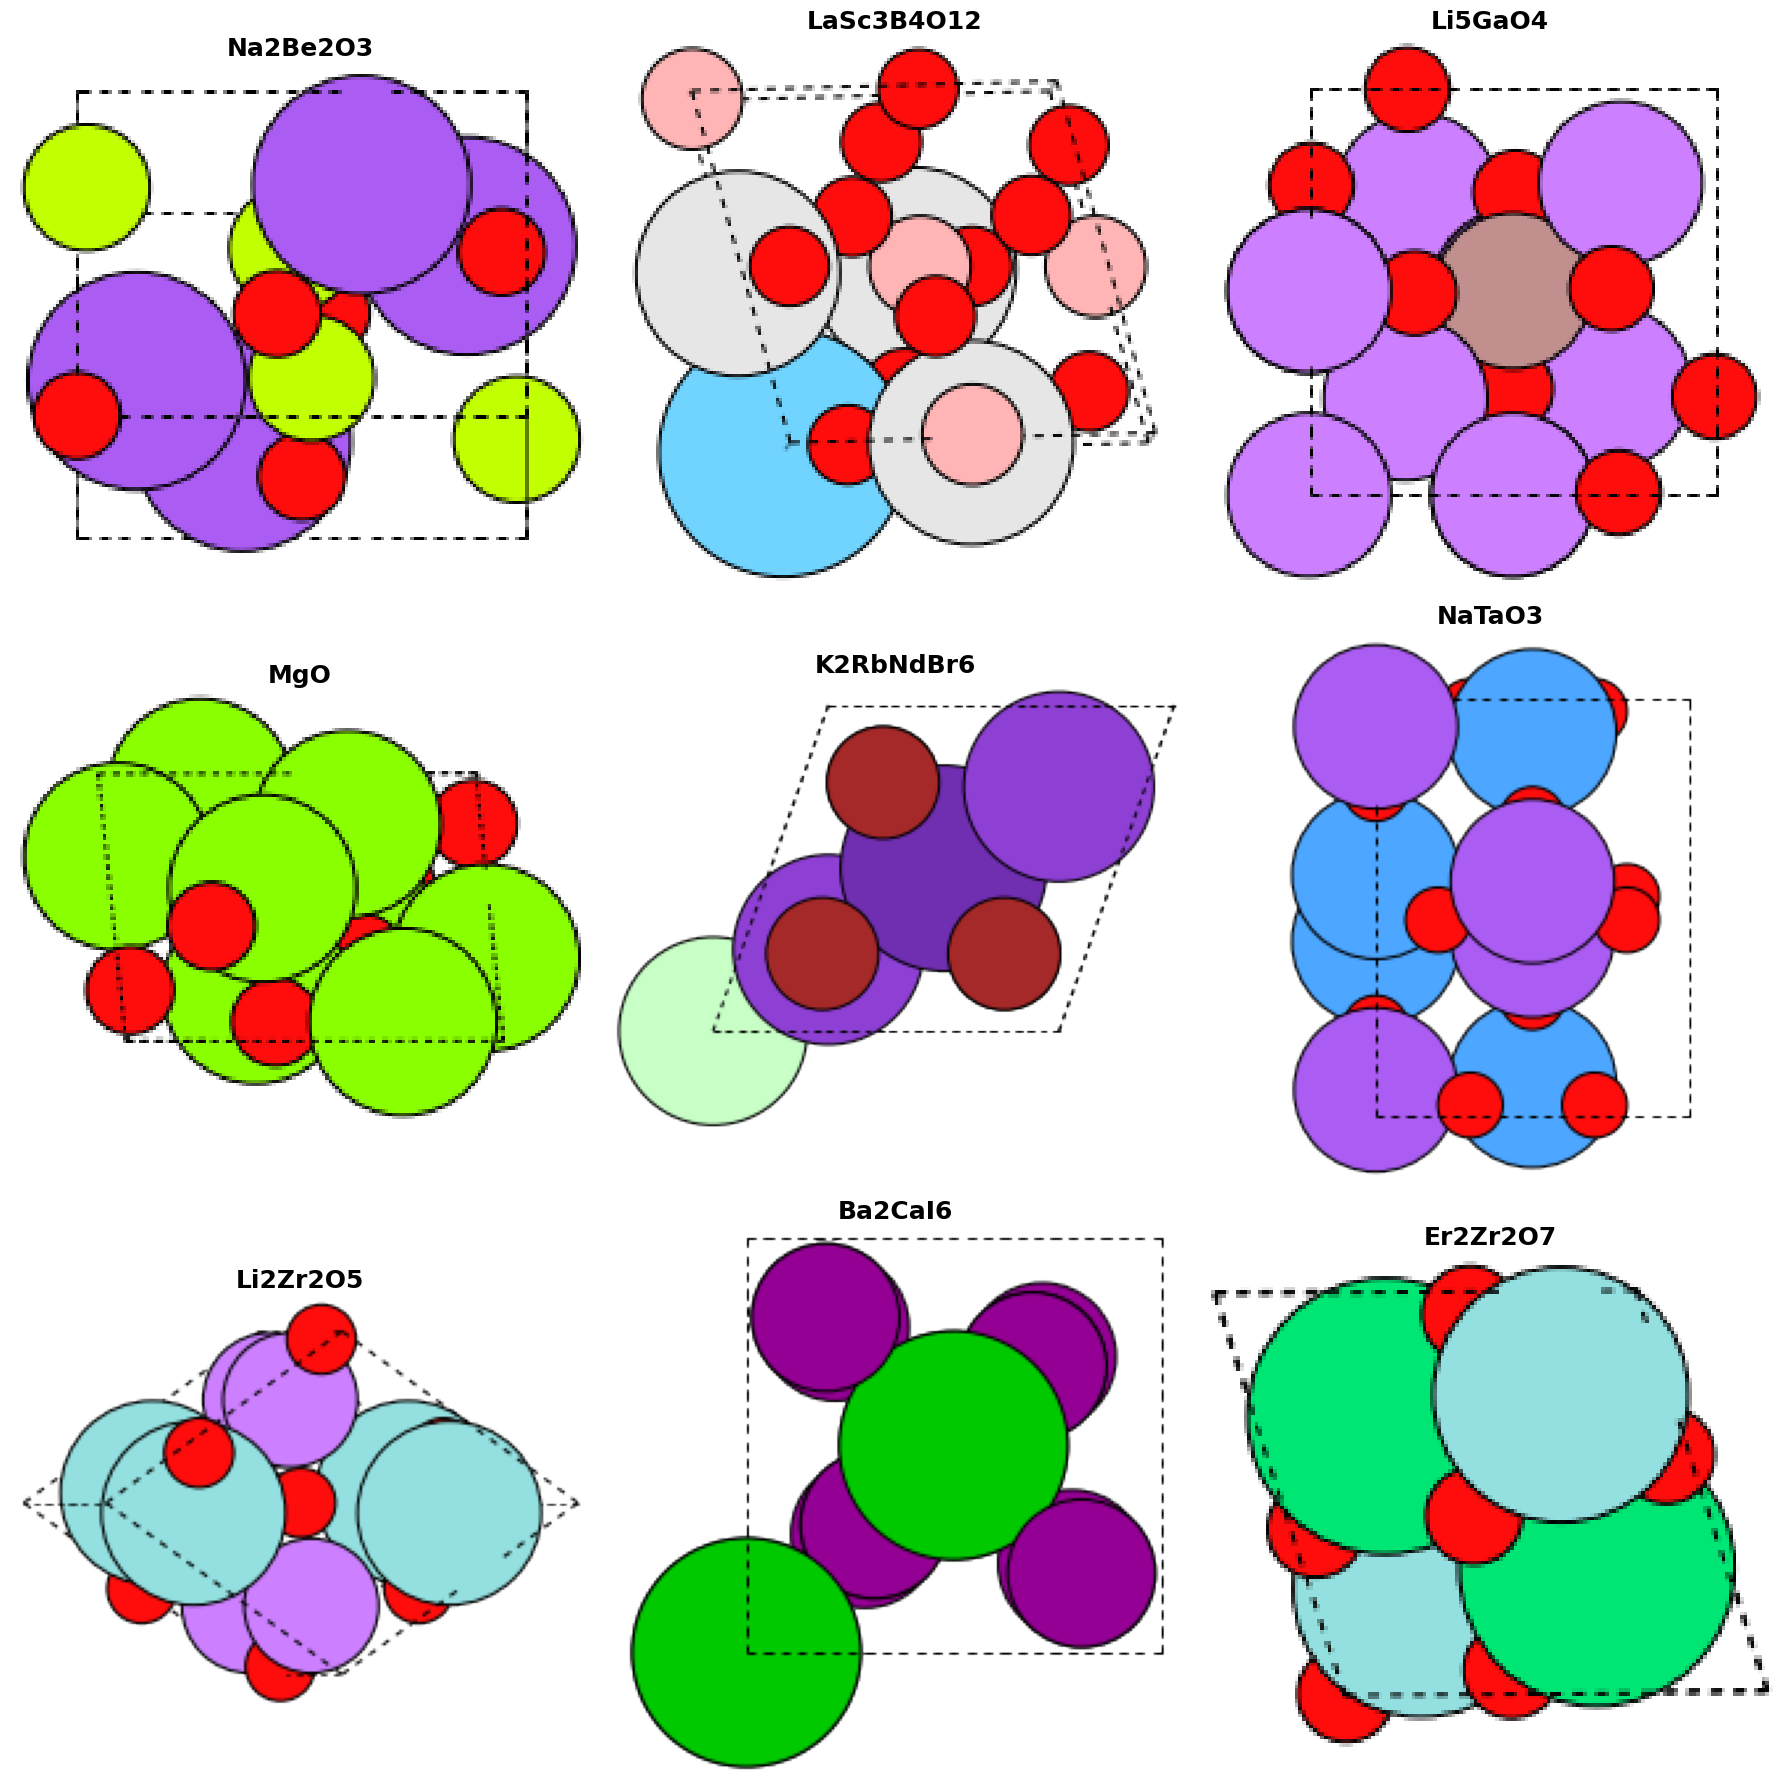

In [11]:
import ast
import matplotlib.pyplot as plt
from jarvis.core.atoms import Atoms
from ase.io import write
from PIL import Image
import os

# Work with the top false positives dataframe
df_vis = top_false_candidates.reset_index(drop=True)

# Ensure atoms_obj column exists
df_vis["atoms_obj"] = df_vis["atoms"].apply(
    lambda x: Atoms.from_dict(ast.literal_eval(x)) if isinstance(x, str) else Atoms.from_dict(x)
)

# Save top 9 candidates as PNGs into store_dir
filenames = []
for i in range(len(df_vis)):
    atoms_obj = df_vis.loc[i, "atoms_obj"].ase_converter()
    formula = df_vis.loc[i, "formula"]
    prob = float(df_vis.loc[i, "pred_prob"])

    fname = os.path.join(store_dir, f"{base_name}_candidate_{i+1}.png")
    write(fname, atoms_obj)   # ASE renders a 3D snapshot
    filenames.append((fname, formula, prob))

# Create 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
axes = axes.flatten()

for i, (fname, formula, prob) in enumerate(filenames):
    img = Image.open(fname)
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"{formula}", fontsize=18, fontweight="bold")

plt.tight_layout()
subplot_path = os.path.join(store_dir, f"{base_name}_top9_false_candidates_subplot.png")
plt.savefig(subplot_path, dpi=300, bbox_inches="tight")
# plt.close(fig)

# Caption for the figure
caption = (
    "3x3 grid of structural snapshots for the top 9 false positive candidates. "
    "Each panel shows an ASE-rendered atomic configuration with the chemical formula "
    "as the title. These candidates were selected by highest predicted probability, "
    "providing a visual overview of their structural diversity."
)

print(f"Saved 3x3 subplot figure of top 9 false positives to {subplot_path}")
print("Caption:", caption)

## Create a Large Set for Automated Discovery

In [12]:
# Take top 100 false positives
top_100_false_candidates = false_positives.head(100)

cols_to_show = ["formula", "pred_prob", "optb88vdw_bandgap", "ehull", "spg_symbol", "formation_energy_peratom", ]
#top_100_false_candidates[cols_to_show]
print(top_100_false_candidates[cols_to_show].to_string(index=False))

     formula  pred_prob  optb88vdw_bandgap  ehull spg_symbol  formation_energy_peratom
    Na2Be2O3   0.998788              3.284 0.1518     P2_1/c                  -2.24526
  LaSc3B4O12   0.998765              3.945 0.1090        R32                  -3.15813
     Li5GaO4   0.998723              3.882 0.1717   P4_22_12                  -1.95569
         MgO   0.998700              3.184 0.1123       Ibam                  -2.92225
   K2RbNdBr6   0.998700              3.783 0.1491      Fm-3m                  -1.76605
      NaTaO3   0.998678              3.670 0.1832       Ima2                  -2.68287
    Li2Zr2O5   0.998660              3.922 0.1060       C2/c                  -3.12676
     Ba2CaI6   0.998645              3.598 0.1004   P4_2/mnm                  -1.73952
    Er2Zr2O7   0.998635              4.416 0.1146       C2/m                  -3.67376
      BaSrI4   0.998586              3.439 0.1104     Cmc2_1                  -1.73439
       HoHO2   0.998561              4.257 

# Observations on Top 100 False Positive Candidates

### Bandgap Trends
- Most candidates exhibit bandgaps between 3–5 eV, placing them in the wide‑bandgap semiconductor or insulator regime.  
- Examples include CaCO3 (~5.1 eV) and LuAlO3 (~5.4 eV), which are highly insulating.  
- A few compounds such as NaBS2 and Tb3Si2S8I show bandgaps closer to 2.4–2.5 eV, at the lower edge of transparency.  
- This suggests the model is surfacing materials that could be optically transparent but were not labeled as candidates in the dataset.

### Stability (Ehull)
- Many candidates have ehull values <0.2 eV/atom, indicating reasonable thermodynamic stability.  
- Several are essentially on the hull (~0.0 eV/atom), e.g. NaBS2, Tb3Si2S8I, BaZnCO3F2, Na3EuC3O9.  
- These are particularly interesting because they combine high predicted probability with strong stability.

### Structural Diversity
- Space groups range widely:  
  - Fm-3m (cubic, highly symmetric) appears repeatedly (e.g. K3PrBr6, K3AlBr6, BiF3).  
  - Pnma, C2/c, and P21/c also recur, showing the model is confident across multiple symmetry families.  
- Common motifs include oxides (MgO, ZrO2, CaCO3, TiO2), halides (K2RbNdBr6, Ba2CaI6), and mixed anion compounds (WOF4, BaZnCO3F2).

### Formation Energy
- Most formation energies are negative and substantial (−2 to −3.5 eV/atom), consistent with stable compounds.  
- A few hydrides/nitrides (LiH2N, Rb2MgH4, MgH2) have much smaller magnitudes (~−0.2 to −0.3 eV/atom), suggesting marginal stability.  
- These borderline cases may be where the model is “optimistic” compared to dataset labels.

### Notable Observations
- Repeated entries: MgO, ZrO2, CaCO3, BN, Mg2SiO4 appear multiple times with different space groups — polymorphs. This shows the model is consistently flagging polymorphic variants as promising.  
- Transparent oxides: Many classic transparent oxides (MgO, ZrO2, CaCO3, Al2O3 analogs) are in the list, aligning with physical intuition.  
- Exotic chemistries: Compounds like Tb3Si2S8I or ZnBi6P2O14F2 are less conventional but still predicted with high confidence, hinting at unexplored candidates.

### Next Steps
- Cluster by chemistry: Group oxides, halides, nitrides, etc. to see which families dominate the false positives.  
- Cross‑check with experimental databases: Some of these (MgO, ZrO2, CaCO3) are known transparent insulators... the model is correctly identifying them despite dataset labeling.  
- Visualize bandgap vs. ehull: Scatter plot of top 100 false positives might highlight which are both stable and wide‑bandgap.


## Visualize bandgap vs. ehull

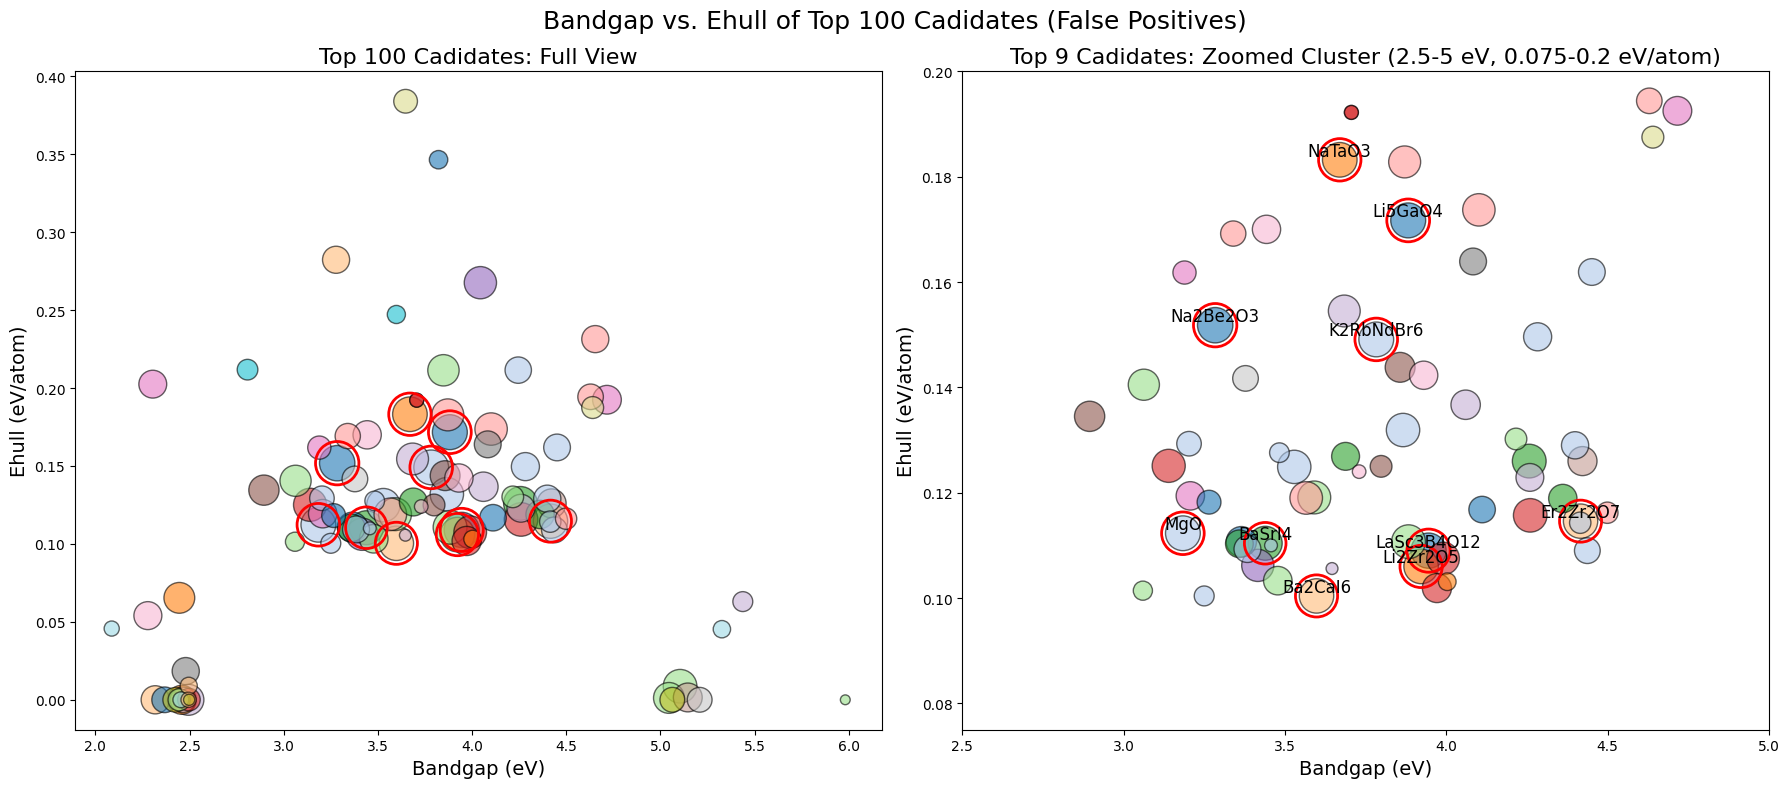

Saved scatter plots to /workspace/data/jarvis/project_gnn_v2_30_epoch_bandgap_vs_ehull_full_and_zoom.png
Caption: Side-by-side scatter plots of the top 100 false positive candidates showing bandgap vs. ehull. Left: full distribution. Right: zoomed view of the central cluster (bandgap 2.5-5 eV, ehull 0.075-0.2 eV/atom). Point size reflects normalized model probability, color encodes space group, and the top 10 formulas are labeled.


In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import os

x = top_100_false_candidates["optb88vdw_bandgap"]
y = top_100_false_candidates["ehull"]

# Normalize probabilities to [50, 300] for marker sizes
prob = top_100_false_candidates["pred_prob"]
sizes = 50 + (prob - prob.min()) / (prob.max() - prob.min() + 1e-6) * 600
colors = top_100_false_candidates["spg_symbol"]

# Create two subplots: full view and zoomed view
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# --- Full view ---
scatter_full = axes[0].scatter(x, y, s=sizes, c=pd.factorize(colors)[0],
                               cmap="tab20", alpha=0.6, edgecolors="k")
axes[0].set_xlabel("Bandgap (eV)", fontsize=14)
axes[0].set_ylabel("Ehull (eV/atom)", fontsize=14)
axes[0].set_title("Top 100 Cadidates: Full View", fontsize=16)

# Highlight top 10
top10 = top_100_false_candidates.nlargest(10, "pred_prob")
#for _, row in top10.iterrows():
#    axes[0].text(row["optb88vdw_bandgap"], row["ehull"],
#                 row["formula"], fontsize=10, ha="center", va="bottom")
axes[0].scatter(top10["optb88vdw_bandgap"], top10["ehull"],
                s=sizes.loc[top10.index]*1.5, facecolors="none",
                edgecolors="red", linewidths=2)

# --- Zoomed view ---
scatter_zoom = axes[1].scatter(x, y, s=sizes, c=pd.factorize(colors)[0],
                               cmap="tab20", alpha=0.6, edgecolors="k")
axes[1].set_xlabel("Bandgap (eV)", fontsize=14)
axes[1].set_ylabel("Ehull (eV/atom)", fontsize=14)
axes[1].set_title("Top 9 Cadidates: Zoomed Cluster (2.5-5 eV, 0.075-0.2 eV/atom)", fontsize=16)

# Highlight top 10 again
for _, row in top10.iterrows():
    axes[1].text(row["optb88vdw_bandgap"], row["ehull"],
                 row["formula"], fontsize=12, ha="center", va="bottom")
axes[1].scatter(top10["optb88vdw_bandgap"], top10["ehull"],
                s=sizes.loc[top10.index]*1.5, facecolors="none",
                edgecolors="red", linewidths=2)

# Zoom limits
axes[1].set_xlim(2.5, 5)
axes[1].set_ylim(0.075, 0.2)

plt.suptitle("Bandgap vs. Ehull of Top 100 Cadidates (False Positives)", fontsize=18)

plt.tight_layout()

# Save figure
fig_path = os.path.join(store_dir, f"{base_name}_bandgap_vs_ehull_full_and_zoom.png")
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

# Caption
caption = (
    "Side-by-side scatter plots of the top 100 false positive candidates showing bandgap vs. ehull. "
    "Left: full distribution. Right: zoomed view of the central cluster (bandgap 2.5-5 eV, ehull 0.075-0.2 eV/atom). "
    "Point size reflects normalized model probability, color encodes space group, and the top 10 formulas are labeled."
)

print(f"Saved scatter plots to {fig_path}")
print("Caption:", caption)
